# 👾 PixelCNN

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset.

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from utils.image import display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
RESIDUAL_BLOCKS = 5
EPOCHS = 2000
LOAD_MODEL = True

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

In [75]:
# Preprocess the data

def preprocess(imgs_int):
    imgs_int = np.pad(imgs_int , ((0,0), (2,2), (2,2)), constant_values= 0)
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs = imgs_int.astype("float32")
    imgs = imgs / 255.0
    
    return imgs, imgs_int

x_train, y_train = preprocess(x_train)

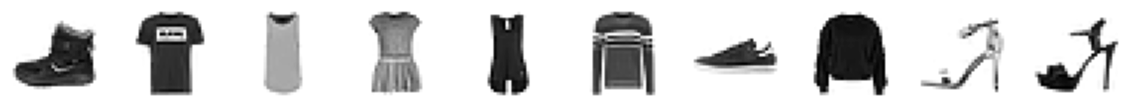

In [76]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the PixelCNN <a name="build"></a>

In [77]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(keras.layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = keras.layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)
    
    def get_config(self):
        cfg = super().get_config()
        return cfg

In [78]:
# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])
    
    def get_config(self):
        cfg = super().get_config()
        return cfg

In [79]:
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = PixelConvLayer(mask_type="A"
                   , filters=256
                   , kernel_size=7
                   , activation="relu"
                   , padding="same")(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=256)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=256,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=256, kernel_size=1, strides=1, activation="softmax", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
pixel_cnn.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 pixel_conv_layer_43 (PixelC  (None, 32, 32, 256)      12800     
 onvLayer)                                                       
                                                                 
 residual_block_25 (Residual  (None, 32, 32, 256)      393856    
 Block)                                                          
                                                                 
 residual_block_26 (Residual  (None, 32, 32, 256)      393856    
 Block)                                                          
                                                                 
 residual_block_27 (Residual  (None, 32, 32, 256)      393856    
 Block)                                                    

In [82]:
if LOAD_MODEL:
    # model.load_weights('./models/model')
    model = keras.models.load_model('./models/pixel_cnn', compile=False)

## 3. Train the PixelCNN <a name="train"></a>

In [83]:
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [84]:
# Create a model save checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img
        
    def sample_from(self, probs, temperature): #<2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)
        
    def generate(self, temperature):
        generated_images = np.zeros(shape=(self.num_img,) + (pixel_cnn.input_shape)[1:])
        batch, rows, cols, channels = generated_images.shape
        
        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images)[:, row, col, :]
                    generated_images[:, row, col, channel] = [self.sample_from(x, temperature) for x in probs]
                    generated_images[:, row, col, channel] /= 255.0
                    
        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature = 1.0)
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        
img_generator_callback = ImageGenerator(num_img=10)

In [86]:

pixel_cnn.fit(
    x_train
    , y_train
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    # , initial_epoch = 9 
    # , steps_per_epoch = 5
    , callbacks=[model_checkpoint_callback, tensorboard_callback, img_generator_callback]
)

Epoch 1/2000
  1/469 [..............................] - ETA: 58:42 - loss: 5.5080

KeyboardInterrupt: 

In [ ]:
# Save the final models
pixel_cnn.save("./models/pixel_cnn")

## 4. Generate images

In [88]:
generated_images = img_generator_callback.generate(temperature = 1.0)

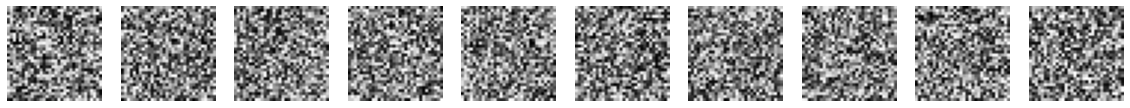

In [89]:
display(generated_images)

In [90]:
generated_images2 = img_generator_callback.generate(temperature = 0.9)

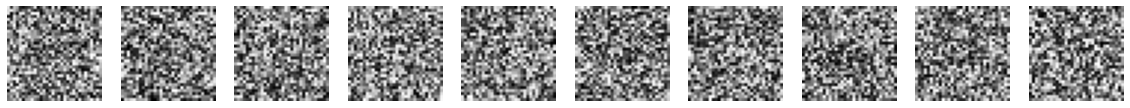

In [91]:
display(generated_images2)